1. Ridge Regression - 1 day ahead prediction

In [8]:
#pip install yfinance
!python -m pip install --upgrade pip
!pip install scikit-learn
!pip install matplotlib
!pip install --upgrade scikit-learn

In [9]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [10]:
#Get data
def get_crypto_price(ticker, start='2018-01-01', end='2025-06-26'):
    df = yf.download(ticker, start=start, end=end)
    df = df.reset_index()
    df = df[['Date', 'Close']].rename(columns={'Date': 'date', 'Close': 'price'})
    df['coin'] = ticker
    return df

# Step 1: Get BTC data
btc_df = get_crypto_price("BTC-USD")

C:\Users\linhd\AppData\Local\Temp\ipykernel_28272\1559033935.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start, end=end)
[*********************100%***********************]  1 of 1 completed


In [11]:
# Step 2: Feature engineering
btc_df['price_lag_1'] = btc_df['price'].shift(1)
btc_df['price_lag_7'] = btc_df['price'].shift(7)
btc_df['price_return_1d'] = btc_df['price'].pct_change(1)
btc_df['price_return_7d'] = btc_df['price'].pct_change(7)
btc_df['rolling_mean_7'] = btc_df['price'].rolling(7).mean()
btc_df['rolling_std_7'] = btc_df['price'].rolling(7).std()

# Step 3: Target variable
btc_df['target'] = btc_df['price'].shift(-1)

# Step 4: Clean up NaN rows
btc_df = btc_df.dropna()

# Optional: Check shape
print("Final data shape:", btc_df.shape)
print(btc_df.head())

Final data shape: (2725, 10)
Price        date         price     coin   price_lag_1   price_lag_7  \
Ticker                  BTC-USD                                        
7      2018-01-08  15170.099609  BTC-USD  16477.599609  13657.200195   
8      2018-01-09  14595.400391  BTC-USD  15170.099609  14982.099609   
9      2018-01-10  14973.299805  BTC-USD  14595.400391  15201.000000   
10     2018-01-11  13405.799805  BTC-USD  14973.299805  15599.200195   
11     2018-01-12  13980.599609  BTC-USD  13405.799805  17429.500000   

Price  price_return_1d price_return_7d rolling_mean_7 rolling_std_7  \
Ticker                                                                
7            -0.079350        0.110777   16055.214146   1088.259908   
8            -0.037884       -0.025811   15999.971401   1159.308475   
9             0.025892       -0.014979   15967.442801   1188.294950   
10           -0.104686       -0.140610   15654.099888   1539.014571   
11            0.042877       -0.197877  

In [12]:
# Save date column to match later with test set
dates = btc_df['date'].copy()

In [13]:
# Step 5: Define input features and target
features = ['price_lag_1', 'price_lag_7', 'price_return_1d', 
            'price_return_7d', 'rolling_mean_7', 'rolling_std_7']

X = btc_df[features]
y = btc_df['target']

# Save the date column
dates = btc_df['date'].copy()

# Step 6: Split into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

# Match date indices for test set
test_dates = btc_df.loc[X_test.index, 'date']

# Step 7: Train a Ridge Regression model
model = Ridge()
model.fit(X_train, y_train)
preds = model.predict(X_test)

# Step 8: Evaluate
rmse = np.sqrt(mean_squared_error(y_test, preds))
print(f"RMSE: {rmse:.2f}")

RMSE: 2445.60


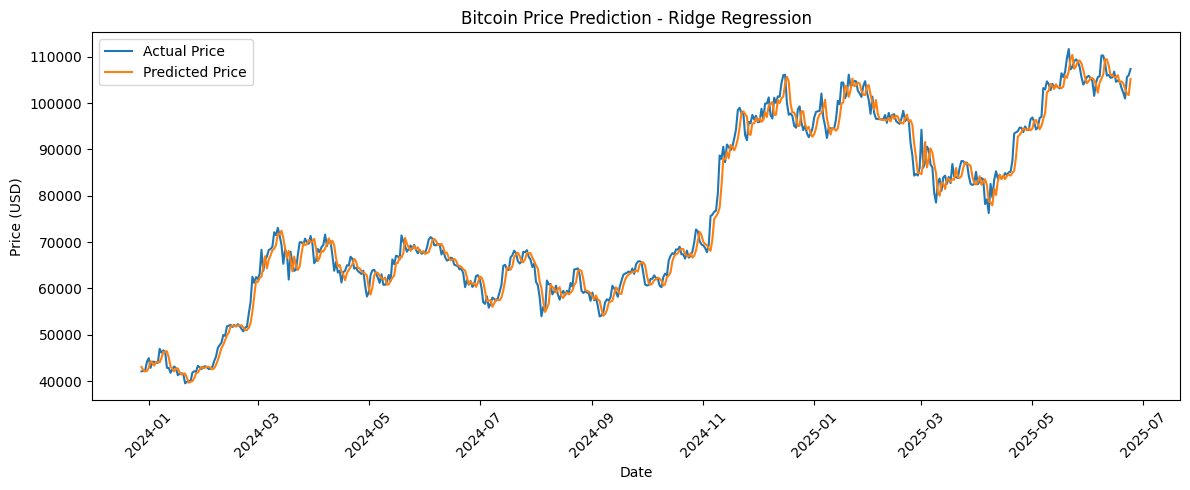

In [14]:
# Get corresponding dates from the test set
plt.figure(figsize=(12, 5))
plt.plot(test_dates, y_test.values, label='Actual Price')
plt.plot(test_dates, preds, label='Predicted Price')
plt.title('Bitcoin Price Prediction - Ridge Regression')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()